<h1><center> ECS759P Artificial Intelligence: Coursework 1 </center></h1>
<h3><center> Mughees Asif &#9644; 180288337 </center></h3>

---

## Agenda-based Search

### Abstract

The following notebook represents the implementation of __[Depth-First Search (DFS)](https://en.wikipedia.org/wiki/Depth-first_search)__, __[Breadth-First Search (BFS)](https://en.wikipedia.org/wiki/Breadth-first_search)__, and __[Uniform Cost Search (UCS)](https://www.educative.io/edpresso/what-is-uniform-cost-search)__ to find an optimal path from one London underground station to another. The aforementioned search algorithms were implemented using standard programming techniques and data structures available with the Python programming language. The graph to represent the data set was developed using __[NetworkX](https://networkx.org/)__ and the results indicate a suitable representation as all the required routes were found. An improved UCS implementation was also implemented to improve the practicality of the original algorithm. Moreover, the __[A* Search](https://en.wikipedia.org/wiki/A*_search_algorithm)__ algorithm was also implemented to observe the effect of using __[heuristics](https://en.wikipedia.org/wiki/Heuristic)__ on common search problems. 

## Contents <a class="anchor" id="contents"></a>

&nbsp;&nbsp;**1. [Imports](#imports)** <br />

&nbsp;&nbsp;**2. [Graph](#graph)** <br />

&nbsp;&nbsp;**3. [Search Algorithms](#search-algos)** <br />
&nbsp;&nbsp;&nbsp;&nbsp; _3.1: [Depth-First Search (DFS)](#dfs)_ <br />
&nbsp;&nbsp;&nbsp;&nbsp; _3.2: [Breadth-First Search (BFS)](#bfs)_ <br />
&nbsp;&nbsp;&nbsp;&nbsp; _3.3: [Uniform Cost Search (UCS)](#ucs)_ <br />

&nbsp;&nbsp;**4. [Improved cost function](#ucs-new)** <br />

&nbsp;&nbsp;**5. [Heuristic Search](#hs)** <br />
&nbsp;&nbsp;&nbsp;&nbsp; _5.1: [A* Search](#a-star)_ <br />

<div class="alert alert-block alert-info">
<b>Tip:</b> To return to the contents, press the ☝ icon.</div>

## 1. Imports <a class="anchor" id="imports"></a> [☝](#contents)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from csv import reader
import random
import heapq
from heapq import heappush, heappop
from itertools import count

import networkx as nx 
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.algorithms.shortest_paths.weighted import _weight_function
from networkx.classes.function import path_weight

## 2. Graph <a class="anchor" id="graph"></a>  [☝](#contents)

Firstly, we need to extract the relevant data from the `csv` file. Each row in the raw data is presented as:
```
[StartingStation], [EndingStation], [TubeLine], [AverageTimeTaken], [MainZone], [SecondaryZone]
```

A generic function to process the data by removing redundant whitespace and punctuation marks.

In [2]:
# Clean up the data in line with our purpose
def process_string(string):
    return string.replace(" ","").replace('"',"")

The graph nodes represent the `StartingStation` and the `EndingStation`, while the weights are denoted by the `AverageTimeTaken` to reach from one station to another. The `networkX` constructor takes a dictionary as an argument so we will build a dictionary of all three parameters. 

In [3]:
# Parse the `csv` file as a dictionary
filename = 'tubedata.csv'

with open(filename, mode='r') as infile:
    tube_map = {
        process_string(rows[0]): {
            process_string(rows[1]): {
                'weight':float(process_string(rows[3]))
            }
        } 
        for rows in reader(infile)
    }

# Use the dictionary to build the graph
tube_map = nx.Graph(tube_map)
print(tube_map)

Graph with 271 nodes and 261 edges


<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>show_weighted_graph</code> function is taken from the lab material to aid the visualisation of the generated graph.
</div>

We can now use the following function to visualise the data as a graph.

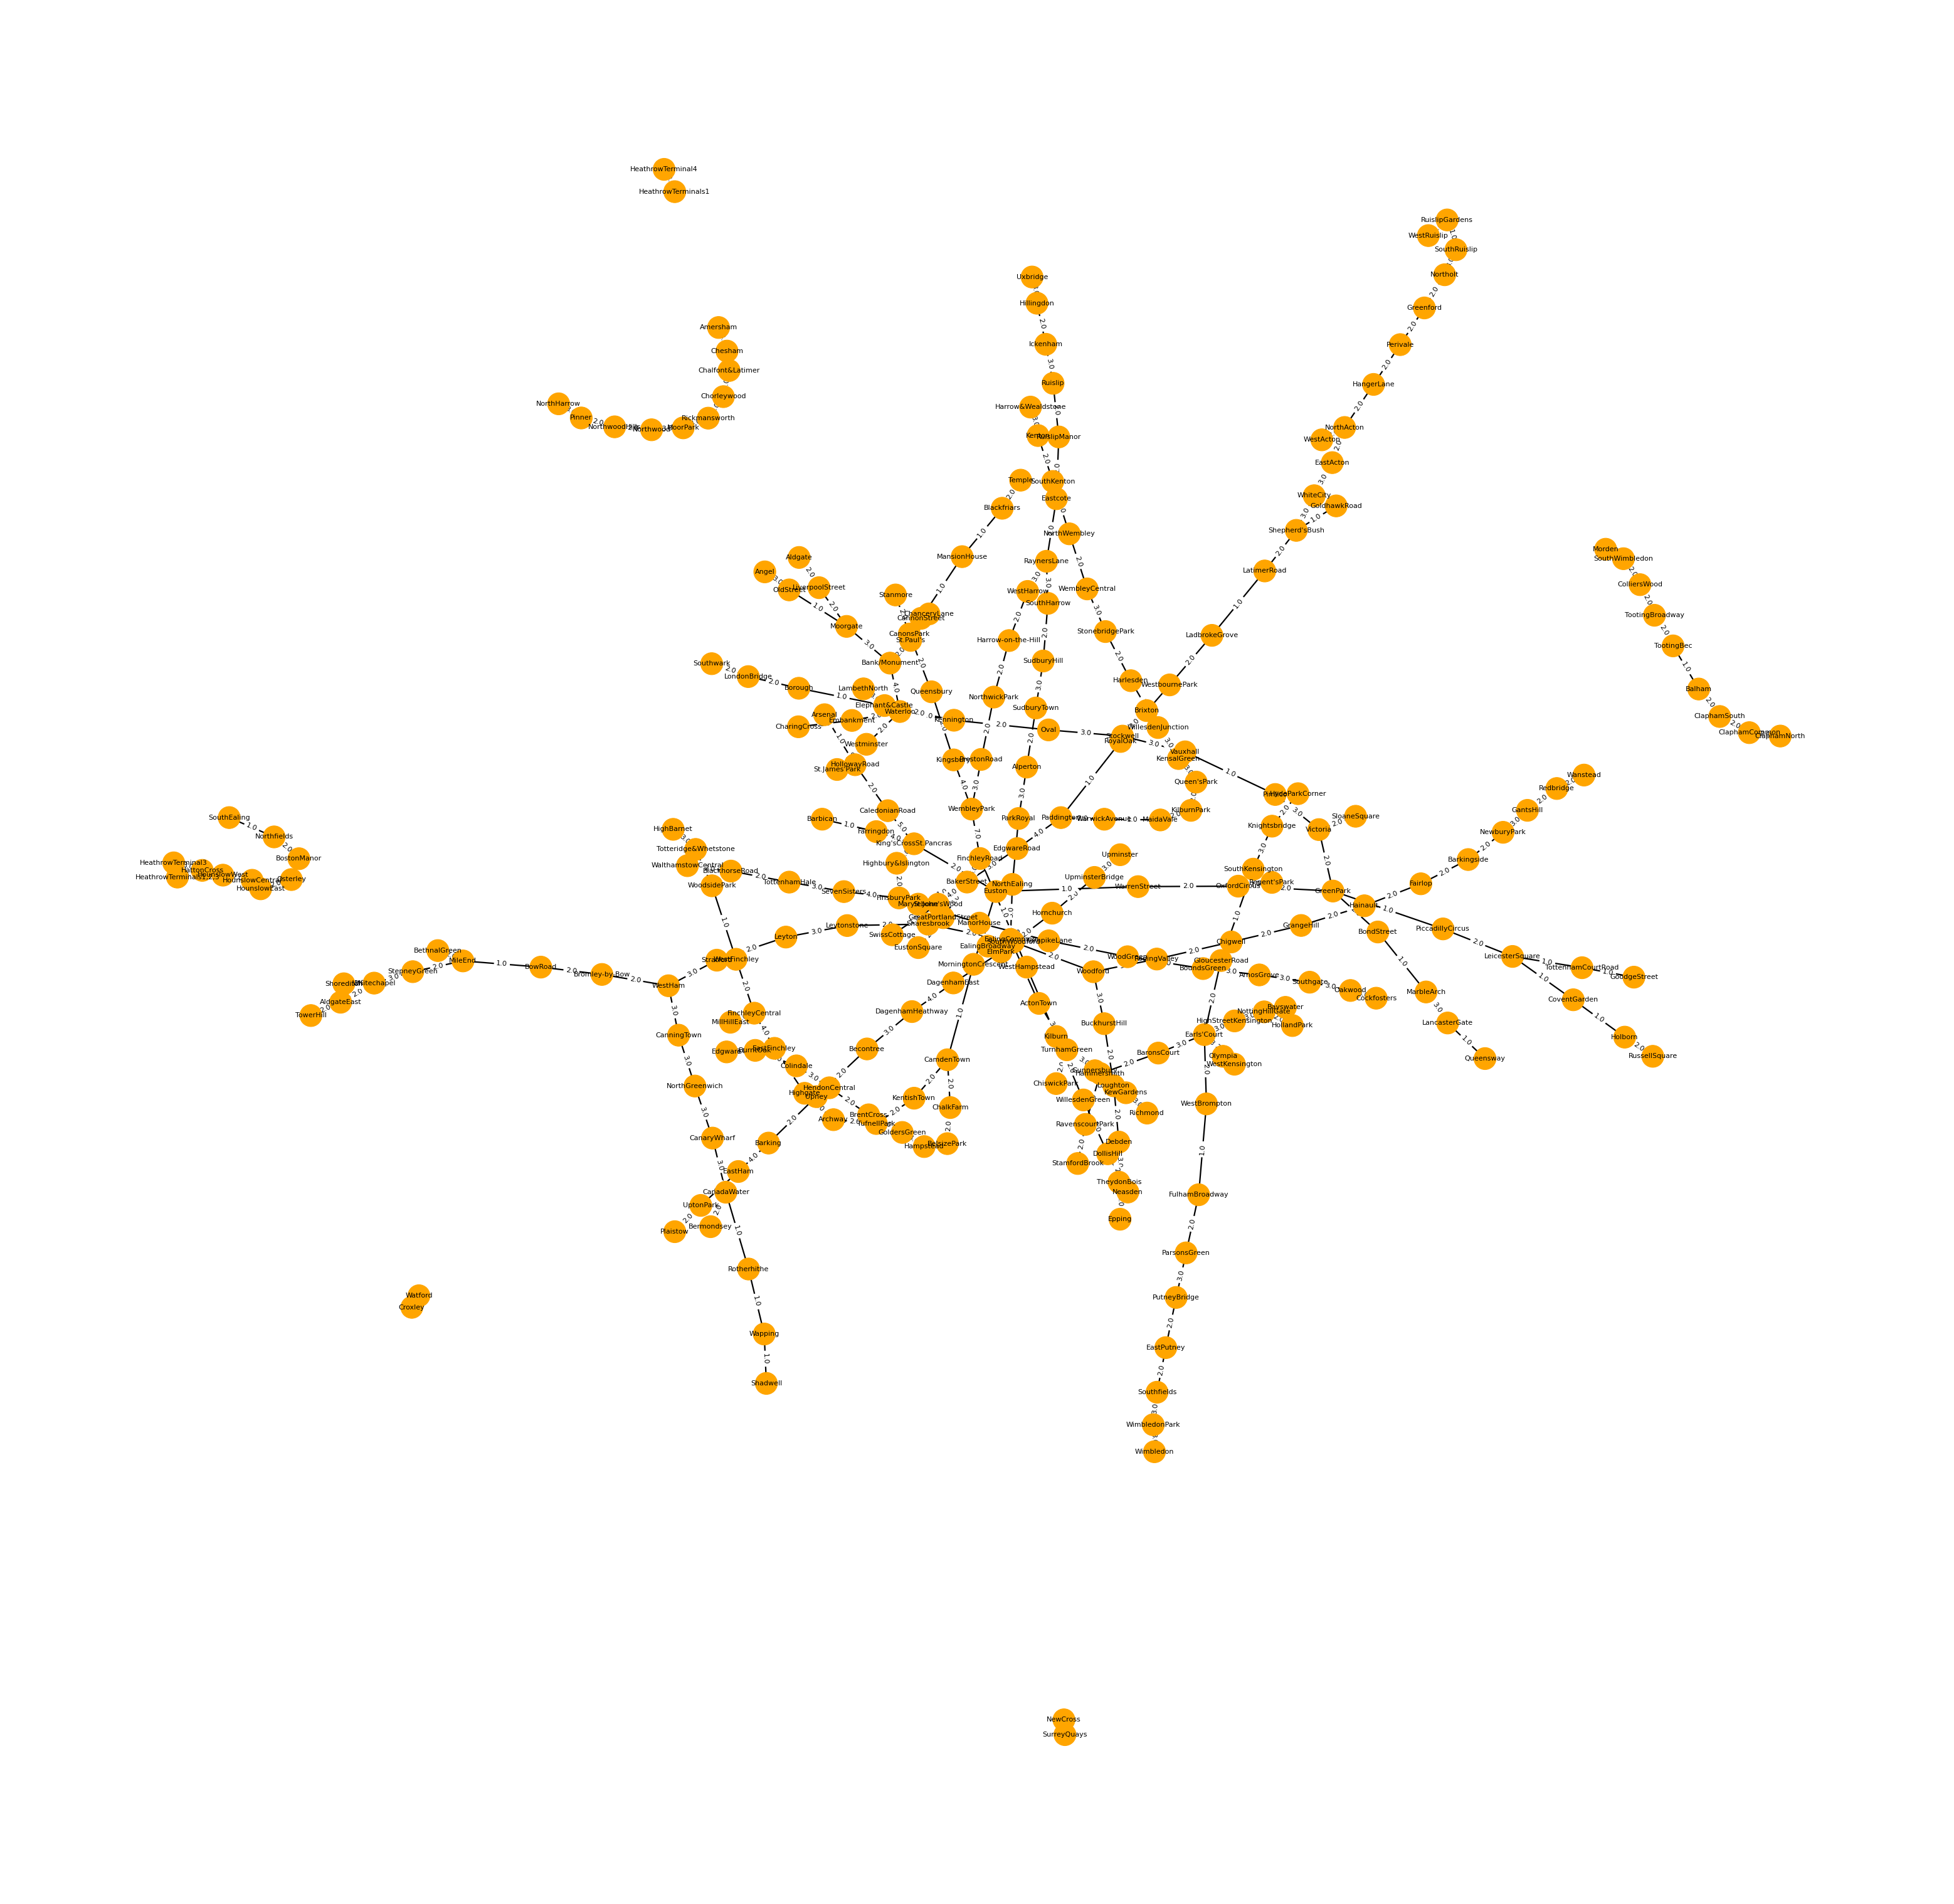

In [4]:
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
  # Allocate the given fig_size in order to have space for each node
  plt.figure(num=None, figsize=fig_size, dpi=80)
  plt.axis('off')
  # Compute the position of each vertex in order to display it nicely
  nodes_position = nx.spring_layout(networkx_graph) 
  # You can change the different layouts depending on your graph
  # Extract the weights corresponding to each edge in the graph
  edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
  # Draw the nodes (you can change the color)
  nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,  
                         node_color = ["orange"]*networkx_graph.number_of_nodes())
  # Draw only the edges
  nx.draw_networkx_edges(networkx_graph, nodes_position, 
                         edgelist=list(networkx_graph.edges), width=2)
  # Add the weights
  nx.draw_networkx_edge_labels(networkx_graph, nodes_position, 
                               edge_labels = edges_weights)
  # Add the labels of the nodes
  nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size, 
                          font_family='sans-serif')
  plt.axis('off')
  plt.show()

show_weighted_graph(tube_map, 1000, 10, (50,50))

## 3. Search Algorithms <a class="anchor" id="search-algos"></a>  [☝](#contents)

<div class="alert alert-block alert-danger">
<b>Note:</b> The following algorithms have been designed using techniques from the official QM labs, and where appropriate, the algorithms follow similar structure to generic algorithms found on GitHub/Stack Overflow. If any code has been reused, it has been referenced to indicate the source.
</div>

We will first define the test cases, where the `start` and `end` arrays highlight the starting and ending stations, respectively. 

In [5]:
# Starting stations
start = ['Euston', 'CanadaWater', 'EalingBroadway', 'BakerStreet', 'StonebridgePark', 'Stratford']
# Ending stations
end = ['Victoria', 'Stratford', 'SouthKensington', 'WembleyPark', 'MaidaVale', 'TowerHill']

Helper function to print out the paths taken by the algorithms.
<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>construct_path_from_root</code> function is from the official QM labs.
</div>

In [6]:
def construct_path_from_root(node, root):  
    path_from_root = [node['label']]
    while node['parent']:
        node = node['parent']
        path_from_root += [node['label']] 
    return path_from_root

### 3.1 Depth-First Search (DFS) <a class="anchor" id="dfs"></a>  [☝](#contents)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>dfs</code> function is from the official QM labs.
</div>

Time complexity: **$O(b^m)$** 

Space complexity: **$O(bm)$**

where, $b$ is the branching factor and $m$ is the maximum depth of the tree.

In [7]:
def dfs(nxobject, initial, goal, compute_exploration_cost=False):
    
    frontier = [{'label':initial, 'parent':None}]  
    explored = {initial}
    number_of_explored_nodes = 1 

    while frontier:
        node = frontier.pop() 
        number_of_explored_nodes += 1
        if node['label']==goal:
            if compute_exploration_cost:
                print('cost: {}'.format(number_of_explored_nodes))
            return node

        neighbours = nxobject.neighbors(node['label'])
        for child_label in neighbours:

            child = {'label':child_label, 'parent':node}
            if child_label not in explored:
                frontier.append(child)
                explored.add(child_label)      
    return explored

Testing the `dfs` function:

In [8]:
for i in range(len(start)):
    print('\nExample no.', i+1, '\n', '-'*10)
    routes = dfs(tube_map, start[i], end[i], True)
    path = construct_path_from_root(routes, start[i])
    print(path)


Example no. 1 
 ----------
cost: 6
['Victoria', 'GreenPark', 'OxfordCircus', 'WarrenStreet', 'Euston']

Example no. 2 
 ----------
cost: 8
['Stratford', 'WestHam', 'CanningTown', 'NorthGreenwich', 'CanaryWharf', 'CanadaWater']

Example no. 3 
 ----------
cost: 24
['SouthKensington', 'GloucesterRoad', "Earls'Court", 'BaronsCourt', 'Hammersmith', 'TurnhamGreen', 'ActonTown', 'EalingCommon', 'EalingBroadway']

Example no. 4 
 ----------
cost: 8
['WembleyPark', 'FinchleyRoad', 'BakerStreet']

Example no. 5 
 ----------
cost: 8
['MaidaVale', 'KilburnPark', "Queen'sPark", 'KensalGreen', 'WillesdenJunction', 'Harlesden', 'StonebridgePark']

Example no. 6 
 ----------
cost: 19
['TowerHill', 'AldgateEast', 'Whitechapel', 'StepneyGreen', 'MileEnd', 'BowRoad', 'Bromley-by-Bow', 'WestHam', 'Stratford']


### 3.2 Breadth-First Search (BFS) <a class="anchor" id="bfs"></a>  [☝](#contents)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>bfs</code> function is from the official QM labs.
</div>

Time complexity: **$O(b^d)$** 

Space complexity: **$O(b^d)$** 

where, $b$ is the branching factor and $d$ is the depth of shallowest solution.

In [9]:
def bfs(nxobject, initial, goal, compute_exploration_cost=False):
    
    if initial == goal: 
        return None
    
    number_of_explored_nodes = 1    
    frontier = [{'label':initial, 'parent':None}]  
    explored = {initial}
    
    while frontier:
        node = frontier.pop()
        
        neighbours = nxobject.neighbors(node['label'])

        for child_label in neighbours:
            child = {'label':child_label, 'parent':node}
            if child_label==goal:
                if compute_exploration_cost:
                    print('cost: {}'.format(number_of_explored_nodes))
                return child
 
            if child_label not in explored:
                frontier = [child] + frontier # added to the left of the list, so a FIFO!
                number_of_explored_nodes += 1
                explored.add(child_label)
            
    return None


Testing the `bfs` function:

In [10]:
for i in range(len(start)):
    print('\nExample no.', i+1, '\n', '-'*10)
    routes = bfs(tube_map, start[i], end[i], True)
    path = construct_path_from_root(routes, start[i])
    print(path)


Example no. 1 
 ----------
cost: 23
['Victoria', 'GreenPark', 'OxfordCircus', 'WarrenStreet', 'Euston']

Example no. 2 
 ----------
cost: 10
['Stratford', 'WestHam', 'CanningTown', 'NorthGreenwich', 'CanaryWharf', 'CanadaWater']

Example no. 3 
 ----------
cost: 25
['SouthKensington', 'GloucesterRoad', "Earls'Court", 'BaronsCourt', 'Hammersmith', 'TurnhamGreen', 'ActonTown', 'EalingCommon', 'EalingBroadway']

Example no. 4 
 ----------
cost: 8
['WembleyPark', 'FinchleyRoad', 'BakerStreet']

Example no. 5 
 ----------
cost: 11
['MaidaVale', 'KilburnPark', "Queen'sPark", 'KensalGreen', 'WillesdenJunction', 'Harlesden', 'StonebridgePark']

Example no. 6 
 ----------
cost: 28
['TowerHill', 'AldgateEast', 'Whitechapel', 'StepneyGreen', 'MileEnd', 'BowRoad', 'Bromley-by-Bow', 'WestHam', 'Stratford']


### 3.3 Uniform Cost Search (UCS) <a class="anchor" id="ucs"></a>  [☝](#contents)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>ucs</code> function has been developed using <b><a href='https://github.com/santiagoLabs/UniformCostSearch-Shortest_path_between_2_UK_cities/blob/master/src/ucs.py'>this</a></b> GitHub repository.
</div>

Time complexity: **$O(b^{1+\frac{C}{\epsilon}})$**  

Space complexity: **$O(b^{1+\frac{C}{\epsilon}})$** 

where, $C$ is the optimal cost and $\epsilon$ is the cost of passing through _each_ node.

In [11]:
def ucs(graph, start, end):
    queue = []
    tracker = {}

    # A tuple to represent each node:
    # (cost, origin, [path])
    node = (0, start, [start])

    # Use a dictionary to keep track of the elements inside the queue
    tracker[node[1]] = [node[0], node[2]]

    # Insert the node inside the queue
    heapq.heappush(queue, node)
    explored = set()

    while queue:
        if len(queue) == 0:
            return None

        # Pop element with lowest path cost in the queue
        node = heapq.heappop(queue)
        # Delete the popped node dictionary the element that has been popped
        del tracker[node[1]]

        # Check if the solution has been found
        if node[1] == end:
            return node
        explored.add(node[1])
        # Develop the path to the current node using a list
        neighbours = list(graph.neighbors(node[1]))
        path = node[2]
        for neighbor in neighbours:
            path.append(neighbor)
            # Use the average time taken to calculate cost
            average_time = graph.get_edge_data(node[1], neighbor)["weight"]
            cost = node[0] + average_time
            # create the child node with updated cost
            child_node = (cost, neighbor, path)
            # Check the child node is not explored and not in frontier thorough the dictionary
            if neighbor not in explored and neighbor not in tracker:
                heapq.heappush(queue, child_node)
                tracker[neighbor] = [child_node[0], child_node[2]]
            elif neighbor in tracker:
                if child_node[0] < tracker[neighbor][0]:
                    node_to_remove = (tracker[neighbor][0], neighbor, tracker[neighbor][1])
                    queue.remove(node_to_remove)
                    heapq.heapify(queue)
                    del tracker[neighbor]

                    heapq.heappush(queue, child_node)
                    tracker[neighbor] = [child_node[0], child_node[2]]
            path = path[:-1]

Testing the `ucs` function:

In [12]:
for i in range(len(start)):
        print('\nExample no.', i+1, '\n', '-'*10)
        routes = ucs(tube_map, start[i], end[i])
        tube_stations = routes[2]
        costs = int(routes[0])
        print("cost:", costs)
        print(tube_stations)


Example no. 1 
 ----------
cost: 7
['Euston', 'WarrenStreet', 'OxfordCircus', 'GreenPark', 'Victoria']

Example no. 2 
 ----------
cost: 15
['CanadaWater', 'CanaryWharf', 'NorthGreenwich', 'CanningTown', 'WestHam', 'Stratford']

Example no. 3 
 ----------
cost: 20
['EalingBroadway', 'EalingCommon', 'ActonTown', 'TurnhamGreen', 'Hammersmith', 'BaronsCourt', "Earls'Court", 'GloucesterRoad', 'SouthKensington']

Example no. 4 
 ----------
cost: 13
['BakerStreet', 'FinchleyRoad', 'WembleyPark']

Example no. 5 
 ----------
cost: 14
['StonebridgePark', 'Harlesden', 'WillesdenJunction', 'KensalGreen', "Queen'sPark", 'KilburnPark', 'MaidaVale']

Example no. 6 
 ----------
cost: 17
['Stratford', 'WestHam', 'Bromley-by-Bow', 'BowRoad', 'MileEnd', 'StepneyGreen', 'Whitechapel', 'AldgateEast', 'TowerHill']


## 4. Improved cost function <a class="anchor" id="ucs-new"></a>  [☝](#contents)

The improved cost function takes in a graph that has the `TubeLine` and the `AverageTimeTaken` as values to further improve the vanilla UCS function from [Section 3.3](#ucs).

The intuition behind the methodoloy is to use the tube line information to better guide the search algorithm. For example, when the algorithm expands from one node to another and if the tubeline _does not_ remain the same, then we can add a penalty with a scalar value of 1 to the overall cost of the search. This translates into if an individual was travelling on the underground service and they changed their tube line, they would have had to use more time to get to their destination.

#### Pseudocode 

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
def <font color = "green">ucs_new</font>(graph, start, end):<br>
&nbsp;&nbsp;&nbsp;&nbsp; frontier ← a priority queue<br>
&nbsp;&nbsp;&nbsp;&nbsp; reached ← empty set<br>
&nbsp;&nbsp;&nbsp;&nbsp; solution ← failure<br>
&nbsp;&nbsp;&nbsp;&nbsp; start_tube_line ← origin<br>
&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">while</font> frontier.size() != empty && top(frontier) &lt; solution <font color = "green">do</font>:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "blue">parent</font> ← pop(frontier)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">for</font> child <font color = "green">in</font> successors(parent) <font color = "green">do</font>:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; s ← child.state <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">if</font> s != reached <font color = "green">or</font> child &lt; reached[s] <font color = "green">then</font>:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; current_tube_line ← child <br>
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">if</font>(current_tube_line != start_tube_line):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; cost += average_time_taken + 1 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">else</font>:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; cost += average_time_taken<br>  
</div>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; add child to the frontier <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">if</font> child == goal && child &lt; solution <font color = "green">then</font>:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; solution = child <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font color = "green">return</font> solution<br>
</div>

In [13]:
# Parse the csv file and save a dictionary with an added parameter of the tubelines
with open(filename, mode='r') as infile:
    tube_map_new = {
        process_string(rows[0]): {
            process_string(rows[1]): {
                'weight': float(process_string(rows[3])), 'tube_line': process_string(rows[2])
            }
        } 
        for rows in reader(infile)
    }

tube_dict = tube_map_new
tube_map_new = nx.Graph(tube_map_new)
print(tube_map_new)

Graph with 271 nodes and 261 edges


In [14]:
def ucs_new(graph, start, end):
    queue = []
    tracker = {}

    # A tuple to represent each node:
    # (cost, origin, [path])
    node = (0, start, [start])

    # Get the starting tube_line
    start_tube_line = tube_dict.get(start, {}).get('tube_line')

    # Use a dictionary to keep track of the elements inside the queue
    tracker[node[1]] = [node[0], node[2]]

    # Insert the node inside the queue
    heapq.heappush(queue, node)
    explored = set()

    while queue:
        if len(queue) == 0:
            return None

        # Pop element with lowest path cost in the queue
        node = heapq.heappop(queue)
        # Delete the popped node dictionary the element that has been popped
        del tracker[node[1]]

        # Check if the solution has been found
        if node[1] == end:
            return node
        explored.add(node[1])
        # Develop the path to the current node using a list
        neighbours = list(graph.neighbors(node[1]))
        path = node[2]
        for neighbor in neighbours:
            path.append(neighbor)
            # Use the average time taken to calculate cost
            average_time = graph.get_edge_data(node[1], neighbor)['weight']
            current_tube_line = graph.get_edge_data(node[1], neighbor)['tube_line']

            # Check if the tubeline is the same as starting tubeline
            if (current_tube_line != start_tube_line):
                cost = node[0] + average_time + 1
            else:
                cost = node[0] + average_time

            # create the child node with updated cost
            child_node = (cost, neighbor, path)
            # Check the child node is not explored and not in frontier thorough the dictionary
            if neighbor not in explored and neighbor not in tracker:
                heapq.heappush(queue, child_node)
                tracker[neighbor] = [child_node[0], child_node[2]]
            elif neighbor in tracker:
                if child_node[0] < tracker[neighbor][0]:
                    node_to_remove = (tracker[neighbor][0], neighbor, tracker[neighbor][1])
                    queue.remove(node_to_remove)
                    heapq.heapify(queue)
                    del tracker[neighbor]

                    heapq.heappush(queue, child_node)
                    tracker[neighbor] = [child_node[0], child_node[2]]
            path = path[:-1]

Testing the `ucs_new` function:

In [15]:
for i in range(len(start)):
    print('\nExample no.', i+1, '\n', '-'*10)
    routes = ucs_new(tube_map_new, start[i], end[i])
    tube_stations = routes[2]
    costs = routes[0]
    print("updated cost =", int(costs))
    print(tube_stations)


Example no. 1 
 ----------
updated cost = 11
['Euston', 'WarrenStreet', 'OxfordCircus', 'GreenPark', 'Victoria']

Example no. 2 
 ----------
updated cost = 20
['CanadaWater', 'CanaryWharf', 'NorthGreenwich', 'CanningTown', 'WestHam', 'Stratford']

Example no. 3 
 ----------
updated cost = 28
['EalingBroadway', 'EalingCommon', 'ActonTown', 'TurnhamGreen', 'Hammersmith', 'BaronsCourt', "Earls'Court", 'GloucesterRoad', 'SouthKensington']

Example no. 4 
 ----------
updated cost = 15
['BakerStreet', 'FinchleyRoad', 'WembleyPark']

Example no. 5 
 ----------
updated cost = 20
['StonebridgePark', 'Harlesden', 'WillesdenJunction', 'KensalGreen', "Queen'sPark", 'KilburnPark', 'MaidaVale']

Example no. 6 
 ----------
updated cost = 25
['Stratford', 'WestHam', 'Bromley-by-Bow', 'BowRoad', 'MileEnd', 'StepneyGreen', 'Whitechapel', 'AldgateEast', 'TowerHill']


## 5. Heuristic Search <a class="anchor" id="hs"></a>  [☝](#contents)

<div class="alert alert-block alert-danger">
<b>Note:</b> I tried implementing multiple variations of the Manhattan/Euclidean distance to calculate the distance along the optimal path. However, I kept getting into problems regarding the representation of the target using a co-ordinate system. Therefore, I added a dummy function <code>h(node, target)</code> that returns a random number bounded between $0$ and $5$ representing roughly, the average time taken between any two given stations. This is not an accurate representation of a heuristic but the following two blocks of commented out code provide an indication of what I would implement if given more time and resources.
</div>

In [16]:
# def manhattan_distance(node):
#     dx = abs(node.x - goal.x)
#     dy = abs(node.y - goal.y)
#     return dx + dy

In [17]:
# def euclidean_distance(node):
#     dx = abs(node.x - goal.x)
#     dy = abs(node.y - goal.y)
#     return math.sqrt(dx * dx + dy * dy)

In [18]:
def h(node, target):
    return random.randint(0,9)

### 5.1 A* Search <a class="anchor" id="a-star"></a>  [☝](#contents)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>astar_path</code> function is the official <b><a href='https://github.com/networkx/networkx'>NetworkX</a></b> implementation.
</div>

Time complexity: **Dependent on the heuristic**  

Space complexity: **$O(b^{d})$** 

where, $b$ is the branching factor and $d$ is the depth of the solution.

In [19]:
"""
Shortest paths and path lengths using the A* ("A star") algorithm.
https://github.com/networkx/networkx/blob/main/networkx/algorithms/shortest_paths/astar.py
"""
def astar_path(G, source, target, heuristic=None, weight="weight"):
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}

    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent

        for neighbor, w in G[curnode].items():
            ncost = dist + weight(curnode, neighbor, w)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
#             print('Heuristic: {}'.format(h))
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

Testing the `astar_path` function:

In [20]:
for i in range(len(start)):
    print('\nExample no.', i+1, '\n', '-'*10)
    routes = astar_path(tube_map, start[i], end[i], heuristic=h)
    cost = path_weight(tube_map, routes, weight="weight")
    print("updated cost =", int(cost))
    print(routes)


Example no. 1 
 ----------
updated cost = 7
['Euston', 'WarrenStreet', 'OxfordCircus', 'GreenPark', 'Victoria']

Example no. 2 
 ----------
updated cost = 15
['CanadaWater', 'CanaryWharf', 'NorthGreenwich', 'CanningTown', 'WestHam', 'Stratford']

Example no. 3 
 ----------
updated cost = 20
['EalingBroadway', 'EalingCommon', 'ActonTown', 'TurnhamGreen', 'Hammersmith', 'BaronsCourt', "Earls'Court", 'GloucesterRoad', 'SouthKensington']

Example no. 4 
 ----------
updated cost = 13
['BakerStreet', 'FinchleyRoad', 'WembleyPark']

Example no. 5 
 ----------
updated cost = 14
['StonebridgePark', 'Harlesden', 'WillesdenJunction', 'KensalGreen', "Queen'sPark", 'KilburnPark', 'MaidaVale']

Example no. 6 
 ----------
updated cost = 17
['Stratford', 'WestHam', 'Bromley-by-Bow', 'BowRoad', 'MileEnd', 'StepneyGreen', 'Whitechapel', 'AldgateEast', 'TowerHill']
